# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data'

import pandas as pd
import numpy as np

import os
import glob
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Outline / Methodology

#### Data organisation
The data for this task is organised in three directories, one for each country. Within each directory there are the virus data for the corresponding country, split to several CSV files, one for each day of a month (all data files concern year 2014).

By looking at the data files, we observe that the periods they cover are not the same. For example, the data for Guinea cover most days of September and just a few days of August, the data for Liberia cover the period from June to December, while the data for Sierra Leone cover the period from August to December. Futhermore, the periods are not continuous, i.e. there are days for which data files are missing. These facts should not affect our analysis.

#### Methodology
For reasons that will become clear later, but that are mostly attributed to missing data, we will aggregate total (suspected+probable+confirmed) cases and deaths. The idea behind this decision is that in cases that data is missing for one of the three categories, we just aggregate the data available.

The first step for each country is to normalise their datasets, namely bring them to a common format, which we will be able to process later in a general way. This normalisation runs some checks on the data and tries to infer and fill in some missing data. For example, some Liberia data files contain the individual numbers for suspected, probable and confirmed cases or deaths, but not the total. In places where it can be safely infered, we fill this value in.

Furthermore, we make checks to find out which categories it is safe to use for the data aggregation. For example, if we do not have enough data for a category, we do not use it (in the sense that we will pick some other variable for the final `DataFrame`). If a category makes no sense (e.g. the end-start of month difference of cumulative sums is negative - that is we resurrected people), we don't use it either.

#### Daily vs. Cumulative data
When considering the required data analysis, we can point out two possible ways of carrying it out:
1. Calculate the mean of daily cases/deaths. This approach will work well if the data indicating daily cases/deaths is consistent and correct. If many such values are missing or, even worse, are falselly zero, the average will suffer. As we will see, the daily data for all three countries is generally either missing, or inconsistent.
2. Aggregate as much cumulative data as possible for the available periods. Then, calculate the difference of the cumulative values for a given month and divide by the number of days available for that month. This a way safer way of calculating things, as we do not depend of each individual day data. If, say, a day's data slipped, this will not affect the overall calculation. Or if, say, a correction was made, we don't need to bother with it, as it will be reflected to the rest of the data.

Our choice was to go with the second approach. The reason will become more clear, as soon as we present the analysis of the data for each country.

We begin by importing some modules and defining some constants...

In [2]:
from datetime import datetime

columns_to_check_cases = [
    'ADA_NEW_CASES_SUSPECT',
    'ADA_NEW_CASES_PROBABLE',
    'ADA_NEW_CASES_CONFIRMED',
    'ADA_NEW_CASES_TOTAL',
    'ADA_CUM_CASES_SUSPECT',
    'ADA_CUM_CASES_PROBABLE',
    'ADA_CUM_CASES_CONFIRMED',
    'ADA_CUM_CASES_TOTAL',
]

columns_to_check_deaths = [
    'ADA_NEW_DEATHS_SUSPECT',
    'ADA_NEW_DEATHS_PROBABLE',
    'ADA_NEW_DEATHS_CONFIRMED',
    'ADA_NEW_DEATHS_TOTAL',
    'ADA_CUM_DEATHS_SUSPECT',
    'ADA_CUM_DEATHS_PROBABLE',
    'ADA_CUM_DEATHS_CONFIRMED',
    'ADA_CUM_DEATHS_TOTAL',
]

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

**Step 1:** We normalise Guinea dataset. As you can see from the execution of the code in the following cell, for the Guinea dataset it is safe to use both the new and cumulative totals. However, if we want to average on individual categories, some data is missing. For example, the daily new **confirmed** deaths values exists in only 1 out of 22 days. It is clear that we cannot rely on that category data.

In [3]:
files = glob.glob(os.path.join(DATA_FOLDER, 'ebola', 'guinea_data', '*.csv'))
columns = ['Date', 'Description', 'Totals']
gdf = pd.concat(pd.read_csv(f, parse_dates=['Date'],
                            usecols=columns,
                            index_col=['Date'])
                for f in files)

# Sort resulting DataFrame by index (Date)
gdf.sort_index(inplace=True)
# Convert Totals column to floats.
gdf['Totals'] = gdf['Totals'].apply(pd.to_numeric, errors='coerce')

# Number of days in Guinea dataset.
number_of_days_in_dataset = len(gdf.index.unique())

# Normalise columns.
conversions = (
    # New cases
    (r"^new.*cases.*suspects$", 'ADA_NEW_CASES_SUSPECT'),
    (r"^new.*cases.*probables$", 'ADA_NEW_CASES_PROBABLE'),
    (r"^new.*cases.*confirmed$", 'ADA_NEW_CASES_CONFIRMED'),
    (r"^total.*new.*cases", 'ADA_NEW_CASES_TOTAL'),
    # Cumulative cases
    (r"^total.*cases.*suspects", 'ADA_CUM_CASES_SUSPECT'),
    (r"^total.*cases.*probables", 'ADA_CUM_CASES_PROBABLE'),
    (r"^total.*cases.*confirmed", 'ADA_CUM_CASES_CONFIRMED'),
    (r"^cumulative.*confirmed.*probable.*suspects", 'ADA_CUM_CASES_TOTAL'),
    # New deaths
    (r"^new.*deaths.*confirmed", 'ADA_NEW_DEATHS_SUSPECT'),
    (r"^new.*deaths.*probables", 'ADA_NEW_DEATHS_PROBABLE'),
    (r"^new.*deaths.*confirmed", 'ADA_NEW_DEATHS_CONFIRMED'),
    (r"^new.*deaths.*registered( today)?$", 'ADA_NEW_DEATHS_TOTAL'),
    # Cumulative deaths
    (r"^total.*deaths.*suspects$", 'ADA_CUM_DEATHS_SUSPECT'),
    (r"^total.*deaths.*probables$", 'ADA_CUM_DEATHS_PROBABLE'),
    (r"^total.*deaths.*confirmed$", 'ADA_CUM_DEATHS_CONFIRMED'),
    (r"^total.*deaths.*confirmed.*probable.*suspects", 'ADA_CUM_DEATHS_TOTAL'),
)

print("Normalising columns for Guinea dataset...", end=' ')
for regex, val in conversions:
    gdf.loc[[re.match(regex, x.lower()) is not None for x in gdf['Description']], 'Description'] = val
print("Done!", end='\n\n')

# Keep only ADA columns.
gdf = gdf.loc[[x.startswith("ADA") for x in gdf['Description']]]

# Make some checks.
print("Checking columns of interest for Guinea dataset...")
print()
print("Checking case-related columns:")
for col in columns_to_check_cases:
    avail = gdf[(gdf.Description == col)].count()['Totals']
    ind = '*' if avail == number_of_days_in_dataset else ' '
    print('[{ind}] {col} ({avail}/{total})'.format(ind=ind, col=col, avail=avail, total=number_of_days_in_dataset))
print()
print("Checking death-related columns:")
for col in columns_to_check_deaths:
    avail = gdf[(gdf.Description == col)].count()['Totals']
    ind = '*' if avail == number_of_days_in_dataset else ' '
    print('[{ind}] {col} ({avail}/{total})'.format(ind=ind, col=col, avail=avail, total=number_of_days_in_dataset))

Normalising columns for Guinea dataset... Done!

Checking columns of interest for Guinea dataset...

Checking case-related columns:
[*] ADA_NEW_CASES_SUSPECT (22/22)
[ ] ADA_NEW_CASES_PROBABLE (21/22)
[*] ADA_NEW_CASES_CONFIRMED (22/22)
[*] ADA_NEW_CASES_TOTAL (22/22)
[*] ADA_CUM_CASES_SUSPECT (22/22)
[*] ADA_CUM_CASES_PROBABLE (22/22)
[*] ADA_CUM_CASES_CONFIRMED (22/22)
[*] ADA_CUM_CASES_TOTAL (22/22)

Checking death-related columns:
[ ] ADA_NEW_DEATHS_SUSPECT (1/22)
[ ] ADA_NEW_DEATHS_PROBABLE (1/22)
[ ] ADA_NEW_DEATHS_CONFIRMED (0/22)
[*] ADA_NEW_DEATHS_TOTAL (22/22)
[ ] ADA_CUM_DEATHS_SUSPECT (21/22)
[*] ADA_CUM_DEATHS_PROBABLE (22/22)
[*] ADA_CUM_DEATHS_CONFIRMED (22/22)
[*] ADA_CUM_DEATHS_TOTAL (22/22)


**Step 2:** We normalise the Liberia dataset. The below code snippet does two jobs:
1. Analyses the data and determines how complete it is, just like with the Guinea data. The output reveals that the Liberia data is way more sparse than the Guinea data, i.e. there is a lot of data missing. For example, there is not indication for daily deaths per individual caregory whatsoever and just half of the samples contain data for the cumulative deaths per individual category. It is clear that we have to average over cumulative totals.

2. Taking into account point 1, tries to fill in some data, so that we can do the analysis. The data might be sparse, but there is something we can exploit. The cumulative data semantics. Since we are averaging per month, even if a lot of "intermediate" cumulative data is missing, we would be very happy if we had the cumulative data for the first and the last day of a month. We can then subtract and divide by the length of the period (days within the month that the period spans). This will give us a good approximation of the average we are after.

Talking more specifically, the code tries to fill in the cumulative cases total, by adding together the individual cumulative values, where they are available. It need to do so only for the first and last day of a given month's data.

In [4]:
files = glob.glob(os.path.join(DATA_FOLDER, 'ebola', 'liberia_data', '*.csv'))
columns = ['Date', 'Variable', 'National']
ldf = pd.concat(pd.read_csv(f, parse_dates=['Date'],
                            usecols=columns,
                            index_col=['Date'])
                for f in files)

# Sort resulting DataFrame by index (Date)
ldf.sort_index(inplace=True)
# Convert Totals column to floats.
ldf['National'] = ldf['National'].apply(pd.to_numeric, errors='coerce')

# Number of days in Liberia dataset.
number_of_days_in_dataset = len(ldf.index.unique())

# Normalise columns.
conversions = (
    # New cases
    (r"^new.case.s..suspected.$", 'ADA_NEW_CASES_SUSPECT'),
    (r"^new.case.s..probable.$", 'ADA_NEW_CASES_PROBABLE'),
    (r"^^new.case.s..confirmed.$", 'ADA_NEW_CASES_CONFIRMED'),
    # Cumulative cases
    (r"^total.suspected.cases$", 'ADA_CUM_CASES_SUSPECT'),
    (r"^total.probable.cases$", 'ADA_CUM_CASES_PROBABLE'),
    (r"^total.confirmed.cases$", 'ADA_CUM_CASES_CONFIRMED'),
    (r"^cumulative.*confirmed.*probable.*and.*suspected.*cases$", 'ADA_CUM_CASES_TOTAL'),
    # New deaths
    (r"^newly.reported.deaths$$", 'ADA_NEW_DEATHS_TOTAL'),
    # Cumulative deaths
    (r"^total.death.s.in.suspected.cases$", 'ADA_CUM_DEATHS_SUSPECT'),
    (r"^total.death.s.in.probable.cases$", 'ADA_CUM_DEATHS_PROBABLE'),
    (r"^total.death.s.in.confirmed.cases$", 'ADA_CUM_DEATHS_CONFIRMED'),
    (r"^total.death.s.in.confirmed(.|\n)*probable.*suspected.cases$", 'ADA_CUM_DEATHS_TOTAL'),
)

print("Normalising columns for Liberia dataset...", end=' ')
for regex, val in conversions:
    ldf.loc[[re.match(regex, x.lower()) is not None for x in ldf['Variable']], 'Variable'] = val
print("Done!", end='\n\n')

# Keep only ADA columns.
ldf = ldf.loc[[x.startswith("ADA") for x in ldf['Variable']]]

# Make some checks.
print("Checking columns of interest for Liberia dataset...")
print()
print("Checking case-related columns:")
for col in columns_to_check_cases:
    avail = ldf[(ldf.Variable == col)].count()['National']
    ind = '*' if avail == number_of_days_in_dataset else ' '
    print('[{ind}] {col} ({avail}/{total})'.format(ind=ind, col=col, avail=avail, total=number_of_days_in_dataset))
print()
print("Checking death-related columns:")
for col in columns_to_check_deaths:
    avail = ldf[(ldf.Variable == col)].count()['National']
    ind = '*' if avail == number_of_days_in_dataset else ' '
    print('[{ind}] {col} ({avail}/{total})'.format(ind=ind, col=col, avail=avail, total=number_of_days_in_dataset))


# Create a DataFrame to put new rows. Will be later appended to main Liberia DataFrame.
extra_df = pd.DataFrame(data={}, index=[], columns=['Variable', 'National'])

def fill_missing_totals(group):
    """Fill the missing totals for a given group."""
    start_key = group.iloc[[0]].index[0]
    end_key = group.iloc[[-1]].index[0]
    
    # Check if we can fill some TOTAL data for the first and last days of the month...
    for key in [start_key, end_key]:
        try:
            start_cases_total = group.loc[group.Variable == 'ADA_CUM_CASES_TOTAL'].loc[key]['National']
        except KeyError:
            start_cases_total = 0
            try:
                start_cases_suspect = group.loc[group.Variable == 'ADA_CUM_CASES_SUSPECT'].loc[key]['National']
                start_cases_total += start_cases_suspect
            except KeyError: pass
            try:
                start_cases_probable = group.loc[group.Variable == 'ADA_CUM_CASES_PROBABLE'].loc[key]['National']
                start_cases_total += start_cases_probable
            except KeyError: pass
            try:
                start_cases_confirmed = group.loc[group.Variable == 'ADA_CUM_CASES_CONFIRMED'].loc[key]['National']
                start_cases_total += start_cases_confirmed
            except KeyError: pass
            extra_df.loc[key] = ['ADA_CUM_CASES_TOTAL', start_cases_total]
    

def check_monthly_totals(group):
    """Checks whether we can make statistics with monthly totals."""
    totals = [
        'ADA_CUM_CASES_SUSPECT',
        'ADA_CUM_CASES_PROBABLE',
        'ADA_CUM_CASES_CONFIRMED',
        'ADA_CUM_CASES_TOTAL',
        'ADA_CUM_DEATHS_SUSPECT',
        'ADA_CUM_DEATHS_PROBABLE',
        'ADA_CUM_DEATHS_CONFIRMED',
        'ADA_CUM_DEATHS_TOTAL',
    ]
    
    start_key = group.iloc[[0]].index[0]
    end_key = group.iloc[[-1]].index[0]
    print()
    print(group.name, ':', start_key.strftime("%Y-%m-%d"), '-', end_key.strftime("%Y-%m-%d"))
    
    for tot in totals:
        try:
            start_total = group.loc[group.Variable == tot].loc[start_key]['National']
            end_total = group.loc[group.Variable == tot].loc[end_key]['National']
            ind = '*' if end_total > start_total else ' '
        except KeyError as e:
            ind = ' '
        print('[{ind}] {total} ({res})'.format(ind=ind, total=tot, res=end_total-start_total))

print()
print("Data is too sparse, will abandon averaging over daily data.")
print("Checking what we can do with totals...")
ldf.groupby(by=lambda x: x.strftime("%Y-%m")).apply(fill_missing_totals)
# extra_df.index = pd.to_datetime(extra_df.index)
ldf = ldf.append(extra_df).sort_index()
ldf.groupby(by=lambda x: x.strftime("%Y-%m")).apply(check_monthly_totals)


Normalising columns for Liberia dataset... Done!

Checking columns of interest for Liberia dataset...

Checking case-related columns:
[ ] ADA_NEW_CASES_SUSPECT (97/100)
[ ] ADA_NEW_CASES_PROBABLE (97/100)
[ ] ADA_NEW_CASES_CONFIRMED (85/100)
[ ] ADA_NEW_CASES_TOTAL (0/100)
[ ] ADA_CUM_CASES_SUSPECT (82/100)
[ ] ADA_CUM_CASES_PROBABLE (81/100)
[ ] ADA_CUM_CASES_CONFIRMED (81/100)
[ ] ADA_CUM_CASES_TOTAL (33/100)

Checking death-related columns:
[ ] ADA_NEW_DEATHS_SUSPECT (0/100)
[ ] ADA_NEW_DEATHS_PROBABLE (0/100)
[ ] ADA_NEW_DEATHS_CONFIRMED (0/100)
[ ] ADA_NEW_DEATHS_TOTAL (88/100)
[ ] ADA_CUM_DEATHS_SUSPECT (57/100)
[ ] ADA_CUM_DEATHS_PROBABLE (57/100)
[ ] ADA_CUM_DEATHS_CONFIRMED (58/100)
[ ] ADA_CUM_DEATHS_TOTAL (98/100)

Data is too sparse, will abandon averaging over daily data.
Checking what we can do with totals...

2014-06 : 2014-06-16 - 2014-06-29
[*] ADA_CUM_CASES_SUSPECT (25.0)
[*] ADA_CUM_CASES_PROBABLE (12.0)
[*] ADA_CUM_CASES_CONFIRMED (31.0)
[*] ADA_CUM_CASES_TOTAL (68.

""


**Step 3:** We normalise the Sierra Leone dataset. We make the following observations:
1. There seem to be enough case data (daily and cumulative). The totals for those are missing, but they can be easily inferred.
2. Regarding the death data, there is no daily data whatsoever, so we cannot use daily values for the aggregation. The good thing is that there are cumulative data, we just need to infer the total.

We follow roughly the same path as with the Liberia dataset. We aggregate as much data as possible for the cumulative totals. We will calculate the average based on the cumulative total difference from the end of a month to the start.

In [5]:
files = glob.glob(os.path.join(DATA_FOLDER, 'ebola', 'sl_data', '*.csv'))
columns = ['date', 'variable', 'National']
sdf = pd.concat(pd.read_csv(f, parse_dates=['date'],
                            usecols=columns,
                            index_col=['date'])
                for f in files)

# Sort resulting DataFrame by index (Date)
sdf.sort_index(inplace=True)
# Convert Totals column to floats.
sdf['National'] = sdf['National'].apply(pd.to_numeric, errors='coerce')

# Number of days in Sierra Leone dataset.
number_of_days_in_dataset = len(sdf.index.unique())

# Normalise columns.
conversions = (
    # New cases
    (r"^new_suspected$", 'ADA_NEW_CASES_SUSPECT'),
    (r"^new_probable$", 'ADA_NEW_CASES_PROBABLE'),
    (r"^new_confirmed$", 'ADA_NEW_CASES_CONFIRMED'),
    # Cumulative cases
    (r"^cum_suspected$", 'ADA_CUM_CASES_SUSPECT'),
    (r"^cum_probable$", 'ADA_CUM_CASES_PROBABLE'),
    (r"^cum_confirmed$", 'ADA_CUM_CASES_CONFIRMED'),
    # Cumulative deaths
    (r"^death_suspected$", 'ADA_CUM_DEATHS_SUSPECT'),
    (r"^death_probable$", 'ADA_CUM_DEATHS_PROBABLE'),
    (r"^death_confirmed$", 'ADA_CUM_DEATHS_CONFIRMED'),
)

print("Normalising columns for Sierra Leone dataset...", end=' ')
for regex, val in conversions:
    sdf.loc[[re.match(regex, x.lower()) is not None for x in sdf['variable']], 'variable'] = val
print("Done!", end='\n\n')

# Keep only ADA columns.
sdf = sdf.loc[[x.startswith("ADA") for x in sdf['variable']]]

# Make some checks.
print("Checking columns of interest for Sierra Leone dataset...")
print()
print("Checking case-related columns:")
for col in columns_to_check_cases:
    avail = sdf[(sdf.variable == col)].count()['National']
    ind = '*' if avail == number_of_days_in_dataset else ' '
    print('[{ind}] {col} ({avail}/{total})'.format(ind=ind, col=col, avail=avail, total=number_of_days_in_dataset))
print()
print("Checking death-related columns:")
for col in columns_to_check_deaths:
    avail = sdf[(sdf.variable == col)].count()['National']
    ind = '*' if avail == number_of_days_in_dataset else ' '
    print('[{ind}] {col} ({avail}/{total})'.format(ind=ind, col=col, avail=avail, total=number_of_days_in_dataset))

# Create two DataFrame to put new rows. Will be later appended to main Liberia DataFrame.
# Here we need two DataFrames in because we will aggregate data from two different categories.
extra_df = {
    'ADA_CUM_CASES_TOTAL': pd.DataFrame(data={}, index=[], columns=['variable', 'National']),
    'ADA_CUM_DEATHS_TOTAL': pd.DataFrame(data={}, index=[], columns=['variable', 'National']),
}

def fill_missing_totals(group):
    """Fill the missing totals for a given group."""
    start_key = group.iloc[[0]].index[0]
    end_key = group.iloc[[-1]].index[0]
    
    # Check if we can fill some TOTAL data for the first and last days of the month...
    for sus_var, prob_var, conf_var, tot_var in [
        ['ADA_CUM_CASES_SUSPECT', 'ADA_CUM_CASES_PROBABLE', 'ADA_CUM_CASES_CONFIRMED', 'ADA_CUM_CASES_TOTAL'],
        ['ADA_CUM_DEATHS_SUSPECT', 'ADA_CUM_DEATHS_PROBABLE', 'ADA_CUM_DEATHS_CONFIRMED', 'ADA_CUM_DEATHS_TOTAL'],
    ]:
        for key in [start_key, end_key]:
            try:
                start_cases_total = group.loc[group.variable == tot_var].loc[key]['National']
            except KeyError:
                start_cases_total = 0
                try:
                    start_cases_suspect = group.loc[group.variable == sus_var].loc[key]['National']
                    start_cases_total += start_cases_suspect if pd.notnull(start_cases_suspect) else 0.0
                except KeyError: pass
                try:
                    start_cases_probable = group.loc[group.variable == prob_var].loc[key]['National']
                    start_cases_total += start_cases_probable if pd.notnull(start_cases_probable) else 0.0
                except KeyError: pass
                try:
                    start_cases_confirmed = group.loc[group.variable == conf_var].loc[key]['National']
                    start_cases_total += start_cases_confirmed if pd.notnull(start_cases_confirmed) else 0.0
                except KeyError: pass
                extra_df[tot_var].loc[key] = [tot_var, start_cases_total]

def check_monthly_totals(group):
    """Checks whether we can make statistics with monthly totals."""
    totals = [
        'ADA_CUM_CASES_SUSPECT',
        'ADA_CUM_CASES_PROBABLE',
        'ADA_CUM_CASES_CONFIRMED',
        'ADA_CUM_CASES_TOTAL',
        'ADA_CUM_DEATHS_SUSPECT',
        'ADA_CUM_DEATHS_PROBABLE',
        'ADA_CUM_DEATHS_CONFIRMED',
        'ADA_CUM_DEATHS_TOTAL',
    ]
    
    start_key = group.iloc[[0]].index[0]
    end_key = group.iloc[[-1]].index[0]
    print()
    print(group.name, ':', start_key.strftime("%Y-%m-%d"), '-', end_key.strftime("%Y-%m-%d"))
    
    for tot in totals:
        try:
            start_total = group.loc[group.variable == tot].loc[start_key]['National']
            end_total = group.loc[group.variable == tot].loc[end_key]['National']
            ind = '*' if end_total > start_total else ' '
        except KeyError as e:
            print(e)
            ind = ' '
        print('[{ind}] {total} ({res})'.format(ind=ind, total=tot, res=end_total-start_total))

        
# Delete the last day of December, as it makes the cumulative difference negative
# (due to missing data).
sdf.drop(sdf[sdf.index.strftime("%Y-%m-%d") == '2014-12-13'].index, inplace=True)
        
print()
print("Data is too sparse, will abandon averaging over daily data.")
print("Checking what we can do with totals...")
sdf.groupby(by=lambda x: x.strftime("%Y-%m")).apply(fill_missing_totals)

# Merge the two extra DataFrames with the main one.
for _, df in extra_df.items():
    sdf = sdf.append(df).sort_index()

sdf.groupby(by=lambda x: x.strftime("%Y-%m")).apply(check_monthly_totals)

Normalising columns for Sierra Leone dataset... Done!

Checking columns of interest for Sierra Leone dataset...

Checking case-related columns:
[ ] ADA_NEW_CASES_SUSPECT (88/103)
[ ] ADA_NEW_CASES_PROBABLE (88/103)
[ ] ADA_NEW_CASES_CONFIRMED (95/103)
[ ] ADA_NEW_CASES_TOTAL (0/103)
[ ] ADA_CUM_CASES_SUSPECT (97/103)
[ ] ADA_CUM_CASES_PROBABLE (97/103)
[ ] ADA_CUM_CASES_CONFIRMED (92/103)
[ ] ADA_CUM_CASES_TOTAL (0/103)

Checking death-related columns:
[ ] ADA_NEW_DEATHS_SUSPECT (0/103)
[ ] ADA_NEW_DEATHS_PROBABLE (0/103)
[ ] ADA_NEW_DEATHS_CONFIRMED (0/103)
[ ] ADA_NEW_DEATHS_TOTAL (0/103)
[ ] ADA_CUM_DEATHS_SUSPECT (96/103)
[ ] ADA_CUM_DEATHS_PROBABLE (96/103)
[ ] ADA_CUM_DEATHS_CONFIRMED (96/103)
[ ] ADA_CUM_DEATHS_TOTAL (0/103)

Data is too sparse, will abandon averaging over daily data.
Checking what we can do with totals...

2014-08 : 2014-08-12 - 2014-08-31
[*] ADA_CUM_CASES_SUSPECT (30.0)
[ ] ADA_CUM_CASES_PROBABLE (0.0)
[*] ADA_CUM_CASES_CONFIRMED (360.0)
[*] ADA_CUM_CASES_TOT

""


We now have all normalised data in three `DataFrame`s, namely `gdf` for Guinea, `ldf` for Liberia and `sdf` for Sierra Leone. In order to calculate the averages we will `groupby` month and apply the `average_on_totals` function, defined below.

In [6]:
# Calculate averages.
def average_on_totals_with_daily(group):
    first = group.iloc[:2]  # Get the first available day of the month.
    first.sort_values(first.columns[0], inplace=True)
    last = group.iloc[-2:]  # Get the last available day of the month.
    last.sort_values(last.columns[0], inplace=True)
    
    # Calculate the timespan of the available days (last - first).
    tspan = (last.index.date[0] - first.index.date[0]).days + 1
    
    facc, fday = first.Totals  # fday := first day daily, facc := first day total
    lacc, lday = last.Totals   # lday := last day daily, lacc := last day total
    
    # Calculate average based on timespan.
    average = (lacc - facc) / tspan
    
    # If we only have a day's data available for a month,
    # just return that day's daily count as the average.
    return round(average, 2) if tspan > 1 else round(fday, 2)

def average_on_totals_without_daily(group):
    first = group.iloc[:1]  # Get the first available day of the month.
    last = group.iloc[-1:]  # Get the last available day of the month.
    
    # Calculate the timespan of the available days (last - first).
    tspan = (last.index.date[0] - first.index.date[0]).days + 1
    
    facc = first.Totals[0]
    lacc = last.Totals[0]
    
    average = (lacc - facc) / tspan
    
    return round(average, 2) if tspan > 1 else np.NaN
    

# Calculate averages for Guinea
print("---> Making calculations for Guinea")
# Define criteria
cases_criteria = [x in ['ADA_CUM_CASES_TOTAL', 'ADA_NEW_CASES_TOTAL'] for x in gdf.Description]
deaths_criteria = [x in ['ADA_CUM_DEATHS_TOTAL', 'ADA_NEW_DEATHS_TOTAL'] for x in gdf.Description]

print("-> Calculating average cases per day for Guinea")
criteria = cases_criteria
guinea_cdf = gdf.loc[criteria] \
                 .groupby(by=lambda x: x.strftime("%Y-%m")) \
                 .apply(average_on_totals_with_daily)
guinea_cdf.name = 'Cases'
print(guinea_cdf)

print("-> Calculating average deaths per day for Guinea")
criteria = deaths_criteria
guinea_ddf = gdf.loc[criteria] \
                 .groupby(by=lambda x: x.strftime("%Y-%m")) \
                 .apply(average_on_totals_with_daily)
guinea_ddf.name = 'Deaths'
print(guinea_ddf)

print()

# Calculate averages for Liberia
print("---> Making calculations for Liberia")
# Define criteria
cases_criteria = [x in ['ADA_CUM_CASES_TOTAL', 'ADA_NEW_CASES_TOTAL'] for x in ldf.Variable]
deaths_criteria = [x in ['ADA_CUM_DEATHS_TOTAL', 'ADA_NEW_DEATHS_TOTAL'] for x in ldf.Variable]

ldf.columns = ['Totals' if x == 'National' else x for x in ldf.columns]

print("-> Calculating average cases per day for Liberia")
criteria = cases_criteria
liberia_cdf = ldf.loc[criteria] \
                 .groupby(by=lambda x: x.strftime("%Y-%m")) \
                 .apply(average_on_totals_without_daily)
liberia_cdf.name = 'Cases'
print(liberia_cdf)

print("-> Calculating average deaths per day for Liberia")
criteria = deaths_criteria
liberia_ddf = ldf.loc[criteria] \
                 .groupby(by=lambda x: x.strftime("%Y-%m")) \
                 .apply(average_on_totals_with_daily)
liberia_ddf.name = 'Deaths'
print(liberia_ddf)

print()

# Calculate averages for Sierra Leone
print("---> Making calculations for Sierra Leone")
# Define criteria
cases_criteria = [x in ['ADA_CUM_CASES_TOTAL', 'ADA_NEW_CASES_TOTAL'] for x in sdf.variable]
deaths_criteria = [x in ['ADA_CUM_DEATHS_TOTAL', 'ADA_NEW_DEATHS_TOTAL'] for x in sdf.variable]

sdf.columns = ['Totals' if x == 'National' else x for x in sdf.columns]

print("-> Calculating average cases per day for Sierra Leone")
criteria = cases_criteria
sierra_cdf = sdf.loc[criteria] \
                .groupby(by=lambda x: x.strftime("%Y-%m")) \
                .apply(average_on_totals_without_daily)
sierra_cdf.name = 'Cases'
print(sierra_cdf)

print("-> Calculating average deaths per day for Sierra Leone")
criteria = deaths_criteria
sierra_ddf = sdf.loc[criteria] \
                .groupby(by=lambda x: x.strftime("%Y-%m")) \
                .apply(average_on_totals_without_daily)
sierra_ddf.name = 'Deaths'
print(sierra_ddf)

for df in [guinea_cdf, guinea_ddf, liberia_cdf, liberia_ddf, sierra_cdf, sierra_ddf]:
    df.index.name = 'Month'

---> Making calculations for Guinea
-> Calculating average cases per day for Guinea
2014-08     9.07
2014-09    13.07
2014-10    34.00
Name: Cases, dtype: float64
-> Calculating average deaths per day for Guinea
2014-08     4.50
2014-09     7.34
2014-10    15.00
Name: Deaths, dtype: float64

---> Making calculations for Liberia
-> Calculating average cases per day for Liberia
2014-06     4.86
2014-07     7.96
2014-08    41.15
2014-09    68.77
2014-10    85.00
2014-11    38.93
2014-12    13.56
Name: Cases, dtype: float64
-> Calculating average deaths per day for Liberia
2014-06     2.36
2014-07     3.23
2014-08    23.26
2014-09    35.13
2014-10    19.84
2014-11    15.76
2014-12    14.33
Name: Deaths, dtype: float64

---> Making calculations for Sierra Leone
-> Calculating average cases per day for Sierra Leone
2014-08    19.50
2014-09    40.53
2014-10    68.74
2014-11    83.55
2014-12    81.00
Name: Cases, dtype: float64
-> Calculating average deaths per day for Sierra Leone
2014-08    

Now, we just need to combine the resulting `DataFrames` containing the averages to one singe `DataFrame`. We chose to indicate missing values with `N/A`s rather than with zeroes, in order to be clear that the data is missing and not mistakenly considered zero.

In [7]:
months = ['2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12']
variables = ['Cases', 'Deaths']
countries = ['Guinea', 'Liberia', 'Sierra Leone']
index = pd.MultiIndex.from_product((months, variables), names=('Month', 'Variable'))
DF = pd.DataFrame(data='N/A',
            index=index,
            columns=countries)

# Assign cases
for df, country in [(guinea_cdf, 'Guinea'), (liberia_cdf, 'Liberia'), (sierra_cdf, 'Sierra Leone')]:
    for month in df.index:
        DF.loc[month, 'Cases'][country] = df[month]

# Assign deaths
for df, country in [(guinea_ddf, 'Guinea'), (liberia_ddf, 'Liberia'), (sierra_ddf, 'Sierra Leone')]:
    for month in df.index:
        DF.loc[month, 'Deaths'][country] = df[month]

DF

Guinea Liberia Sierra Leone
Month   Variable                            
2014-06 Cases       N/A    4.86          N/A
        Deaths      N/A    2.36          N/A
2014-07 Cases       N/A    7.96          N/A
        Deaths      N/A    3.23          N/A
2014-08 Cases      9.07   41.15         19.5
        Deaths      4.5   23.26          6.6
2014-09 Cases     13.07   68.77        40.53
        Deaths     7.34   35.13         5.13
2014-10 Cases        34      85        68.74
        Deaths       15   19.84        27.58
2014-11 Cases       N/A   38.93        83.55
        Deaths      N/A   15.76        14.48
2014-12 Cases       N/A   13.56           81
        Deaths      N/A   14.33         26.5


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

#### Solution

First, we read our 9 excel files and store them into 9 different DataFrames:

In [8]:
mid1 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID1.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid2 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID2.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid3 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID3.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid4 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID4.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid5 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID5.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid6 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID6.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid7 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID7.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid8 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID8.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)
mid9 = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'MID9.xls'), sheetname = 'Sheet 1', index_col = 0, header = None)

We give names to the index and the column:

In [9]:
mid1.index.name = mid2.index.name = mid3.index.name = mid4.index.name = 'Taxonomy'
mid5.index.name = mid6.index.name = mid7.index.name = mid8.index.name = mid9.index.name = 'Taxonomy'

mid1.columns = mid2.columns = mid3.columns = mid4.columns = ['Count']
mid5.columns = mid6.columns = mid7.columns = mid8.columns = mid9.columns = ['Count']

We combine the 9 DataFrames into a single DataFrame, on axis 0 (rows):

In [10]:
mid = pd.concat([mid1, mid2, mid3, mid4, mid5, mid6, mid7, mid8, mid9], axis = 0, 
                keys=['MID1', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6', 'MID7', 'MID8', 'MID9'], names = ["Barcode"])

mid

Count
Barcode Taxonomy                                                 
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      7
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...      3
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      7
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1
        Archaea "Euryarchaeota" Halobacteria Halobacter...      2
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4
        Archaea "Euryarchaeota" Methanococci Methanococ...      1
        Archaea "Euryarchaeota" Methanopyri Methanopyra...     12
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...      2
        Bacteria "Actinobacteria" Actinobacteria Actino...      2
        Bacteria "Actinobacteria" Actinobacteria Actino...      1
        Bacteria "Actinobacteria" Actinobacteria Actino...      1
        Bacteria "Actinobacteria" Actinobacteria Actino...      1
        Bacteria "Actinobacteria" Actinobacteria Actino...      2
        Bacteria "Actinobacteria" Actinobacteria Actino...     53
        Bacteria "Actinobacteria" Actinobacteria Actino...      1
        Bacteria "Actinobacteria" Actinobacteria Actino...      2
        Bacteria "Actinobacteria" Actinobacteria Actino...      3
        Bacteria "Actinobacteria" Actinobacteria Actino...      1
        Bacteria "Actinobacteria" Actinobacteria Actino...     99
        Bacteria "Actinobacteria" Actinobacteria Actino...     17
        Bacteria "Actinobacteria" Actinobacteria Actino...      2
...                                                           ...
MID9    Bacteria "Proteobacteria" Gammaproteobacteria O...     10
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1
        Bacteria "Proteobacteria" Gammaproteobacteria P...      1
        Bacteria "Proteobacteria" Gammaproteobacteria P...     12
        Bacteria "Proteobacteria" Gammaproteobacteria P...      4
        Bacteria "Proteobacteria" Gammaproteobacteria P...    805
        Bacteria "Proteobacteria" Gammaproteobacteria P...    862
        Bacteria "Proteobacteria" Gammaproteobacteria P...     12
        Bacteria "Proteobacteria" Gammaproteobacteria P...   3534
        Bacteria "Proteobacteria" Gammaproteobacteria T...      4
        Bacteria "Proteobacteria" Gammaproteobacteria T...      1
        Bacteria "Proteobacteria" Gammaproteobacteria T...     25
        Bacteria "Proteobacteria" Gammaproteobacteria T...      2
        Bacteria "Proteobacteria" Gammaproteobacteria X...      3
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1
        Bacteria "Proteobacteria" Gammaproteobacteria X...      3
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1
        Bacteria "Synergistetes" Synergistia Synergista...      3
        Bacteria "Tenericutes" Mollicutes Anaeroplasmat...      1
        Bacteria "Tenericutes" Mollicutes Haloplasmatal...     11
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1
        Bacteria "Thermotogae" Thermotogae Thermotogale...     43
        Bacteria "Thermotogae" Thermotogae Thermotogale...     16
        Bacteria "Verrucomicrobia" Opitutae Opitutales ...      1
        Bacteria Cyanobacteria Cya

We read the metadata:

In [11]:
meta = pd.read_excel(os.path.join(DATA_FOLDER, 'microbiome', 'metadata.xls'), sheetname = 'Sheet1', index_col = 0, header = 0)
meta

,GROUP,SAMPLE
BARCODE,,
MID1,EXTRACTION CONTROL,NaN
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


We rename the columns using lower-case letters, except for the first letter, just so that they look prettier:

In [12]:
meta.index.name = "Barcode"
meta.rename(columns = {"GROUP": "Group", "SAMPLE": "Sample"}, inplace = True)
meta

,Group,Sample
Barcode,,
MID1,EXTRACTION CONTROL,NaN
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


We merge the two DataFrames, mid and meta, into a single merged DataFrame and we fill all the NaN values with the tag "unknown". We also remove the index, so that we can reset it from scratch, after we decide exactly how we want to present our data:

In [13]:
merged = pd.merge(mid, meta, how='outer', left_index=True, right_index=True)
# merged.index # True

merged = merged.fillna("unknown")

merged = merged.reset_index()

merged

,Barcode,Taxonomy,Count,Group,Sample
0,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,EXTRACTION CONTROL,unknown
1,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,EXTRACTION CONTROL,unknown
2,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,EXTRACTION CONTROL,unknown
3,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,EXTRACTION CONTROL,unknown
4,MID1,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,EXTRACTION CONTROL,unknown
5,MID1,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,EXTRACTION CONTROL,unknown
6,MID1,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,EXTRACTION CONTROL,unknown
7,MID1,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,EXTRACTION CONTROL,unknown
8,MID1,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,EXTRACTION CONTROL,unknown
9,MID1,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",1,EXTRACTION CONTROL,unknown


We create a pivot table from the merged data, where the taxonomy is the index, the group, sample and barcode are the columns and the count is the value. We fill each blank cell with the value 0. (A blank cell does not mean that the value is not known, but rather that a particular microorganism was not encountered in a specific group of extractions, a specific barcode and with a specific sample type).

We decided to use this type of representation for the data, so as to allow the reader to observe, in a single row, how much a specific microorganism has been detected in various extractions. Since a group can contain several samples and barcodes, we considered appropriate to set it as our first level of columns. Each group (apart from the one called "EXTRACTION CONTROL") seems to use both stool and tissue samples. Thus, we used the sample as our second level of columns. Finally, our last level of columns is the barcode, which seems to be simply an id, without carrying any significant information about the extractions.

In [77]:
final = merged.pivot_table(index=['Taxonomy'], columns=['Group', 'Sample', 'Barcode'], fill_value = 0,
                           aggfunc=np.sum, margins=True)
final

Count           \
Group                                              Control 1            
Sample                                                 stool   tissue   
Barcode                                                 MID7     MID3   
Taxonomy                                                                
Archaea "Crenarchaeota" Thermoprotei Acidilobal...       0.0      1.0   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...       1.0     15.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       8.0     14.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       0.0      0.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       2.0      4.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       0.0      1.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       1.0      1.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       0.0      0.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       1.0      3.0   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       1.0      0.0   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...       5.0      4.0   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...       3.0      2.0   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...       5.0      5.0   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...       0.0      3.0   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...       0.0      1.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...      18.0      7.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       0.0      4.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       0.0      1.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       1.0      0.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       1.0      0.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       2.0      2.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       0.0      1.0   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...       2.0      1.0   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       9.0      0.0   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       2.0      0.0   
Archaea "Euryarchaeota" Halobacteria Halobacter...       0.0      3.0   
Archaea "Euryarchaeota" Halobacteria Halobacter...       0.0      1.0   
Archaea "Euryarchaeota" Halobacteria Halobacter...       0.0      0.0   
Archaea "Euryarchaeota" Halobacteria Halobacter...       3.0      3.0   
Archaea "Euryarchaeota" Halobacteria Halobacter...       0.0      2.0   
...                                                      ...      ...   
Bacteria "Proteobacteria" Gammaproteobacteria X...       0.0      1.0   
Bacteria "Proteobacteria" Gammaproteobacteria X...      80.0      0.0   
Bacteria "Proteobacteria" Gammaproteobacteria X...       0.0      1.0   
Bacteria "Proteobacteria" Gammaproteobacteria X...     133.0      0.0   
Bacteria "Proteobacteria" Gammaproteobacteria X...       1.0      0.0   
Bacteria "Spirochaetes" Spirochaetes Spirochaet...       0.0      0.0   
Bacteria "Synergistetes" Synergistia Synergista...       1.0      2.0   
Bacteria "Synergistetes" Synergistia Synergista...       8.0      3.0   
Bacteria "Synergistetes" Synergistia Synergista...       0.0      0.0   
Bacteria "Tenericutes" Mollicutes Anaeroplasmat...       0.0      0.0   
Bacteria "Tenericutes" Mollicutes Haloplasmatal...       2.0      2.0   
Bacteria "Thermodesulfobacteria" Thermodesulfob...       1.0      0.0   
Bacteria "Thermodesulfobacteria" Thermodesulfob...       3.0      1.0   
Bacteria "Thermotogae" Thermotogae Thermotogale...      15.0     12.0   
Bacteria "Thermotogae" Thermotogae Thermotogale...      16.0      7.0   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...       2.0      1.0   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...     126.0      1.0   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...      39.0      1.0   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...       2.0      0.0   
Bacteria "Verrucomicrobia" Opitutae Puni

We rename the columns using lower-case letters, except for the first letter, just so that they look prettier:

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [15]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [16]:
df = pd.read_excel(DATA_FOLDER+'/titanic.xls', header=0)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [17]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [18]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [19]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [20]:
# find which columns contain at least one NaN
df.columns[pd.isnull(df).sum() > 0].tolist()

['age', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

#  COLUMN: pclass

In [21]:
df.pclass.value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

There's no need to analyze more the column pclass.

#  COLUMN: survived

In [22]:
df.survived.value_counts()

0    809
1    500
Name: survived, dtype: int64

There's no need to analyze more the column survived.

#  COLUMN: name

I do not think that there should be any analysis on the column name, regarding the range of values

#  COLUMN: sex 

In [23]:
df.sex.value_counts()

male      843
female    466
Name: sex, dtype: int64

The values of sex column shall be treated as categorical data

In [24]:
sex_map = {'male': 0, 'female': 1}
df.sex.replace(sex_map, inplace=True)

#  COLUMN: age

In [25]:
df[df.age.isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
15,1,0,"Baumann, Mr. John D",0,NaN,0,0,PC 17318,25.9250,NaN,S,NaN,NaN,"New York, NY"
37,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",0,NaN,0,0,111427,26.5500,NaN,S,9,NaN,"Los Angeles, CA"
40,1,0,"Brewe, Dr. Arthur Jackson",0,NaN,0,0,112379,39.6000,NaN,C,NaN,NaN,"Philadelphia, PA"
46,1,0,"Cairns, Mr. Alexander",0,NaN,0,0,113798,31.0000,NaN,S,NaN,NaN,NaN
59,1,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",1,NaN,0,0,17770,27.7208,NaN,C,5,NaN,"New York, NY"
69,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",1,NaN,0,1,113505,55.0000,E33,S,6,NaN,"St Leonards-on-Sea, England Ohio"
70,1,0,"Chisholm, Mr. Roderick Robert Crispin",0,NaN,0,0,112051,0.0000,NaN,S,NaN,NaN,"Liverpool, England / Belfast"
74,1,0,"Clifford, Mr. George Quincy",0,NaN,0,0,110465,52.0000,A14,S,NaN,NaN,"Stoughton, MA"
80,1,0,"Crafton, Mr. John Bertram",0,NaN,0,0,113791,26.5500,NaN,S,NaN,NaN,"Roachdale, IN"
106,1,0,"Farthing, Mr. John",0,NaN,0,0,PC 17483,221.7792,C95,S,NaN,NaN,NaN


In [26]:
age = df.age.dropna()
age.describe()

count    1046.000000
mean       29.881135
std        14.413500
min         0.166700
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64

The value range of the age column goes from newborn babies(0.166) to 80 years.

# COLUMN: sibsp

sibsp col is of type int64 and the range of values: [0 - 8]

In [27]:
df.sibsp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64

# COLUMN: parch

parch is of type int64 and the range of values: [0 - 9]

In [28]:
df.parch.value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: parch, dtype: int64

# COLUMN: ticket

Thic column is of type object and I do not think there should not be any analysis regarding the range values.

# COLUMN: fare

This column is of type float64 and there are Nan values

In [29]:
fare = df.fare.dropna()
fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

There are some passengers that their fare is 0

# COLUMN: cabin

cabin column is of type object

In [30]:
cabin = df.cabin.dropna()
cabin.describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: cabin, dtype: object

# COLUMN: embarked

In [31]:
emb = df.embarked.dropna()
emb.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

Passengers where embarked from three different ports
In this case we shall use categorical data and represent {S = 0, C = 1, Q = 2}

In [32]:
embarked_map = {'S': 0, 'C': 1, 'Q' : 2}
df.embarked.replace(embarked_map, inplace=True)

In [33]:
df.embarked.value_counts()

0.0    914
1.0    270
2.0    123
Name: embarked, dtype: int64

Regarding the columns boat, body, home.dest there is not any range for the values that makes sense.
Also, the data in the three columns vary, in a way that if we categorize them, it would not improve our analysis.

# QUESTION 2

Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals. 

# Histogram for the travel class

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f86b0b8>]], dtype=object)

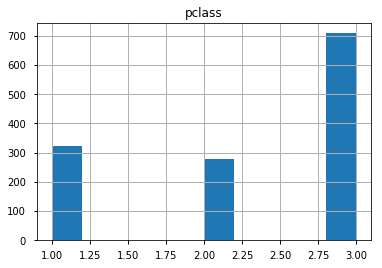

In [34]:
df.hist(column='pclass')

# Histogram for the embarkation port

where 0 stands for port 'S' (Southampton), 1 for 'C' (Cherbourg) and 2 for 'Q' (Queenstown) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f831f98>]], dtype=object)

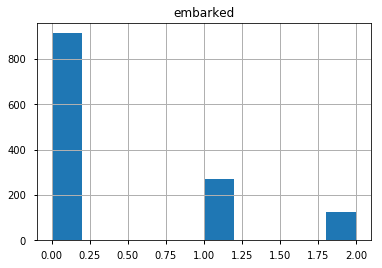

In [35]:
df.hist('embarked')

# Histogram for the sex

where 0 stands for male, 1 for female

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111685ba8>]], dtype=object)

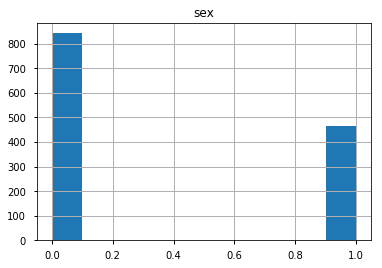

In [36]:
df.hist(column='sex')

# Histogram for the age

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1117b4ba8>]], dtype=object)

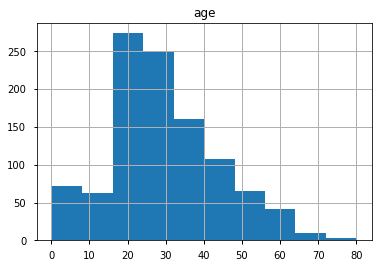

In [37]:
df.hist(column='age')

# Histogram for age using discrete decade intervals 

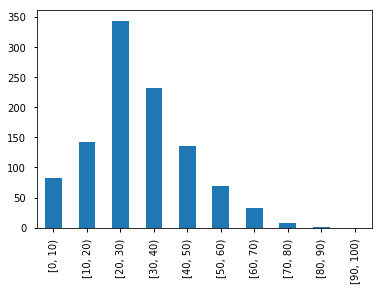

In [38]:
bin_range = np.arange(0, 100+10, 10)
out, bins = pd.cut(df.age, bins = bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False).plot.bar()

# QUESTION 3

Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

In [39]:
df.cabin.isnull().any()

True

In [40]:
df_grouped = df[['pclass','cabin']].dropna(axis=0).groupby(by = df.cabin)

In [41]:
df_grouped.count()

,pclass,cabin
cabin,,
A10,1,1
A11,1,1
A14,1,1
A16,1,1
A18,1,1
A19,1,1
A20,1,1
A21,1,1
A23,1,1


In order to group by floor we add to the dataframe a column that descrives the floor.
This information is obtained by the first letter of the attribute cabin.

In [42]:
df_grouped2 = df[['pclass','cabin']]

In [43]:
df_grouped2 = df_grouped2.dropna(axis=0)
df_grouped2.head()

,pclass,cabin
0,1,B5
1,1,C22 C26
2,1,C22 C26
3,1,C22 C26
4,1,C22 C26


In [44]:
def cabin_floor(cabin):
    return cabin[:1]

In [45]:
df_grouped2['cabin_floor'] = df_grouped2['cabin'].apply(lambda x: cabin_floor(x))

In [46]:
df_grouped2.head()

,pclass,cabin,cabin_floor
0,1,B5,B
1,1,C22 C26,C
2,1,C22 C26,C
3,1,C22 C26,C
4,1,C22 C26,C


In [47]:
df_grouped2 = df_grouped2.drop('cabin', axis=1).groupby(by='cabin_floor')

So now we present the proportion of passengers by cabin floor

In [48]:
df_c = df_grouped2.count()
df_c

,pclass
cabin_floor,
A,22
B,65
C,94
D,46
E,41
F,21
G,5
T,1


([<matplotlib.patches.Wedge at 0x111b35cc0>,
  <matplotlib.text.Text at 0x111adeeb8>])

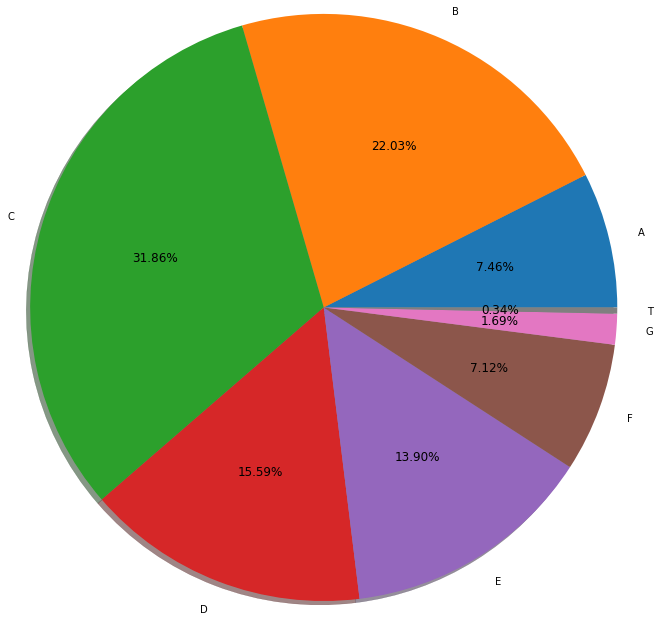

In [49]:
labels = df_c.index
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.subplot(aspect=1)
plt.rcParams["figure.figsize"] = fig_size
plt.pie(df_c['pclass'], labels=labels,  autopct='%1.2f%%', shadow=True, radius=1.5)

# QUESTION 4

For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

In [50]:
cl_gr = df[['survived','pclass','name']].groupby(by=['pclass','survived'])

In [51]:
cl_gr.count()

name
pclass survived      
1      0          123
       1          200
2      0          158
       1          119
3      0          528
       1          181

In [52]:
df_survived = df[['pclass','survived']].groupby('pclass')['survived'].sum()
df_survived

pclass
1    200
2    119
3    181
Name: survived, dtype: int64

In [53]:
df_class_grouped = df[['pclass','survived']].groupby('pclass')['survived'].count()
df_class_grouped

pclass
1    323
2    277
3    709
Name: survived, dtype: int64

In [54]:
df_proportion_survived = df_survived/df_class_grouped * 100
df_proportion_survived

pclass
1    61.919505
2    42.960289
3    25.528914
Name: survived, dtype: float64

In [55]:
type(df_proportion_survived)

pandas.core.series.Series

In [56]:
df_proportion_survived = df_proportion_survived.to_frame()

In [57]:
type(df_proportion_survived)

pandas.core.frame.DataFrame

In [58]:
df_proportion_survived['not survived'] = df_proportion_survived['survived'].apply(lambda x: 100 - x)
df_proportion_survived

,survived,not survived
pclass,,
1,61.919505,38.080495
2,42.960289,57.039711
3,25.528914,74.471086


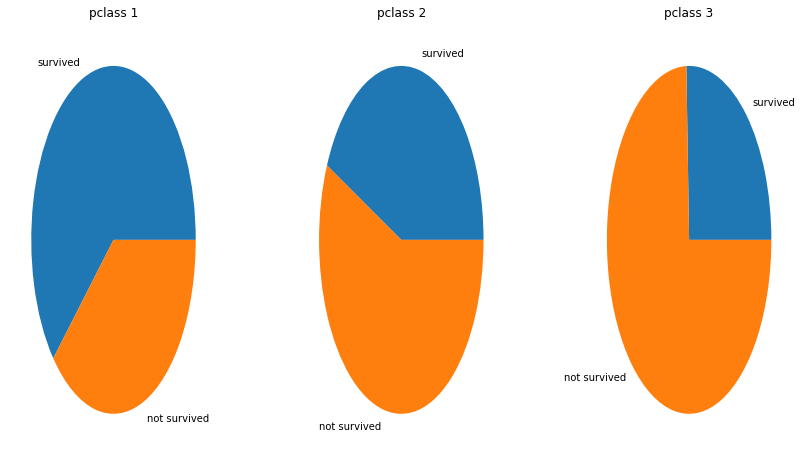

In [59]:
labels = ['survived', 'not survived']
prop = ['proportion']
df_temp = pd.DataFrame(index=labels, columns=prop)
#for i, row in df_proportion_survived.iteritems():
#    df_temp.loc['survived'] = df_proportion_survived[i]
#    df_temp.loc['not survived'] = 100 - df_proportion_survived[i]
#    plt.subplot(aspect=1)
#    plt.pie(df_temp, labels=labels,  autopct='%1.2f%%', shadow=True, radius=1.5)
    
    
    
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for i, (idx, row) in enumerate(df_proportion_survived.iterrows()):
    ax = axes[i % 3]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, startangle=0)
    title = 'pclass '+ str(idx)
    ax.set_title(title)
fig.subplots_adjust(wspace=.4)

# QUESTION 5

Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111b9e470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a193f5748>]], dtype=object)

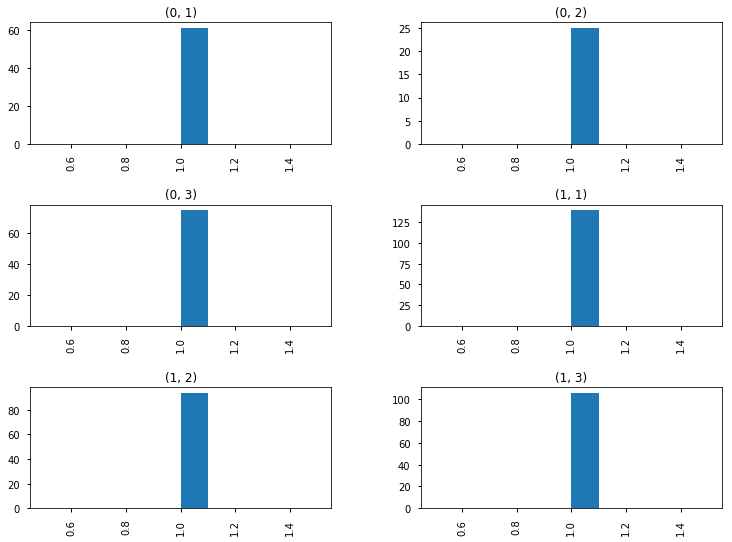

In [60]:
df[df['survived'] == 1].hist(column= 'survived', by=['sex', 'pclass'])
#(0,1) stands for male in class 1, (0,2) for male in class 2, (1,1) for female in class 1 etc 

In [61]:
grouped_class_sex = df.groupby(by=['pclass', 'sex'])['survived']
df_class_sex = grouped_class_sex.sum()

In [62]:
df_class_sex = df_class_sex.to_frame()

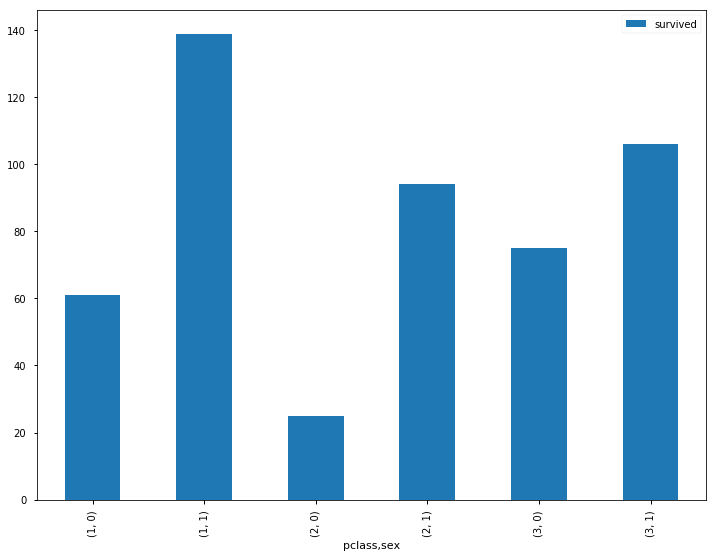

In [63]:
df_class_sex.plot(kind='bar')

In [64]:
df_class_sex

survived
pclass sex          
1      0          61
       1         139
2      0          25
       1          94
3      0          75
       1         106

In [65]:
survived_class_and_sex = df[df.survived == 1].pivot_table(index = 'pclass', columns = 'sex', values='survived', aggfunc='sum')
survived_class_and_sex['Total'] = survived_class_and_sex.sum(axis=1)
percentage = survived_class_and_sex.loc[:,[0,1]].div(survived_class_and_sex['Total'], axis=0) * 100
percentage

sex,0,1
pclass,,
1,30.500000,69.500000
2,21.008403,78.991597
3,41.436464,58.563536


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1990bbe0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a19aece48>]], dtype=object)

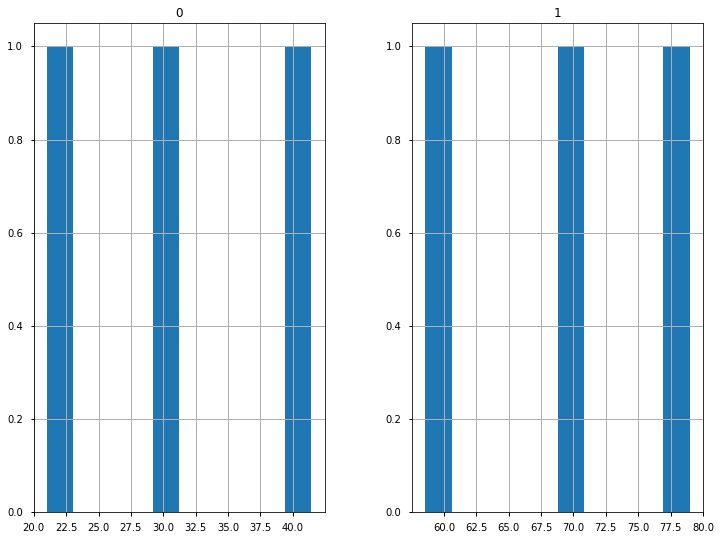

In [66]:
percentage.hist()

The underline graph presents the result in a better way

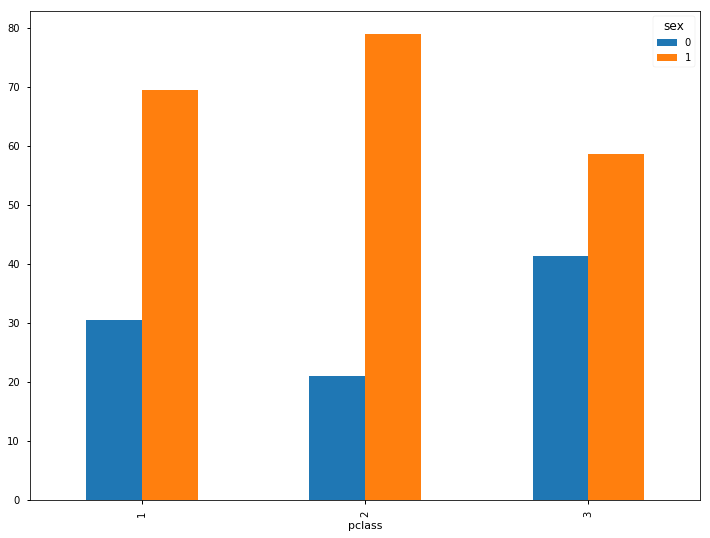

In [67]:
percentage.plot(kind='bar')

# QUESTION 6

Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

We consider that age values < 1, are babies. Since their name is provided we think that removing these values from the dataframe would not be right.

In [68]:
df.dropna(subset=['age'], inplace=True)
df.sort_values(by='age', ascending=True, inplace=True)
df.shape

(1046, 14)

In [69]:
df_age = df['age']
df_age = df_age.sort_values(ascending=True)

In [70]:
populated = np.split(df_age,2)
len(populated[0])

523

In [71]:
populated[0].tail()

431    28.0
546    28.0
707    28.0
527    28.0
572    28.0
Name: age, dtype: float64

In [72]:
populated[1].head()

1126    28.0
203     28.0
1021    28.0
52      28.0
1270    28.0
Name: age, dtype: float64

We created 2 equally age categories, they are separated on the age 28. 

In [73]:
df_cat1 = df.loc[:523, :]
df_cat1.shape

(311, 14)

In [74]:
labels = pd.cut(df.age, bins=2, labels=['age_category1','age_category2'])
df['age_category'] = labels
last_df = df[df.survived == 1].pivot_table(index = ['pclass','sex','age_category'], values='survived', aggfunc='sum')
last_df

survived
pclass sex age_category           
1      0   age_category1        32
           age_category2        21
       1   age_category1        80
           age_category2        48
2      0   age_category1        21
           age_category2         2
       1   age_category1        79
           age_category2        13
3      0   age_category1        57
           age_category2         2
       1   age_category1        68
           age_category2         4

In [75]:
last_df.sum(axis=0)

survived    427
dtype: int64

In [76]:
percentage = last_df.div(last_df.sum(axis=0)) * 100
percentage

survived
pclass sex age_category            
1      0   age_category1   7.494145
           age_category2   4.918033
       1   age_category1  18.735363
           age_category2  11.241218
2      0   age_category1   4.918033
           age_category2   0.468384
       1   age_category1  18.501171
           age_category2   3.044496
3      0   age_category1  13.348946
           age_category2   0.468384
       1   age_category1  15.925059
           age_category2   0.936768